# Exploratory Data Analysis — Daily Minimum Temperatures
Goal: understand data quality, distribution, temporal patterns (trend/seasonality), autocorrelation & stationarity, anomalies, and implications for modeling.


In [21]:

# 0. Imports & utils

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy import stats

# Statsmodels for time series tools
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

plt.rcParams["figure.figsize"] = (12,5)


In [22]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import os

# Load data
df = pd.read_csv('../data/raw/temperatures.csv', parse_dates=['Date'], index_col='Date')

df.head()

,"Daily minimum temperatures in Melbourne, Australia, 1981-1990"
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


our dataFrame consist of 2 columns :the date in the format year-months-day and the corresponding temmperature . 

In [23]:
# we rename the temperature columns
df.rename(columns={'Daily minimum temperatures in Melbourne, Australia, 1981-1990':'temp'}, inplace =True)
df['temp_cleaned'] = pd.to_numeric(df['temp'], errors='coerce')
df.head(1)

,temp,temp_cleaned
Date,,
1981-01-01,20.7,20.7


### Lets reviews the quality of the data

In [24]:
# Shape, head, tail
print("Shape:", df.shape)
display(df.head())
display(df.tail())

# Dtypes & missing values
print(df.dtypes)
print("Missing values per column:\n", df.isnull().sum())

# Duplicates
print("Duplicate rows:", df.reset_index().duplicated(subset=['Date']).sum())


Shape: (3650, 2)


,temp,temp_cleaned
Date,,
1981-01-01,20.7,20.7
1981-01-02,17.9,17.9
1981-01-03,18.8,18.8
1981-01-04,14.6,14.6
1981-01-05,15.8,15.8


,temp,temp_cleaned
Date,,
1990-12-27,14.0,14.0
1990-12-28,13.6,13.6
1990-12-29,13.5,13.5
1990-12-30,15.7,15.7
1990-12-31,13.0,13.0


temp             object
temp_cleaned    float64
dtype: object
Missing values per column:
 temp            0
temp_cleaned    3
dtype: int64
Duplicate rows: 0


Index freq before reindex: None
Missing dates after reindex: 2


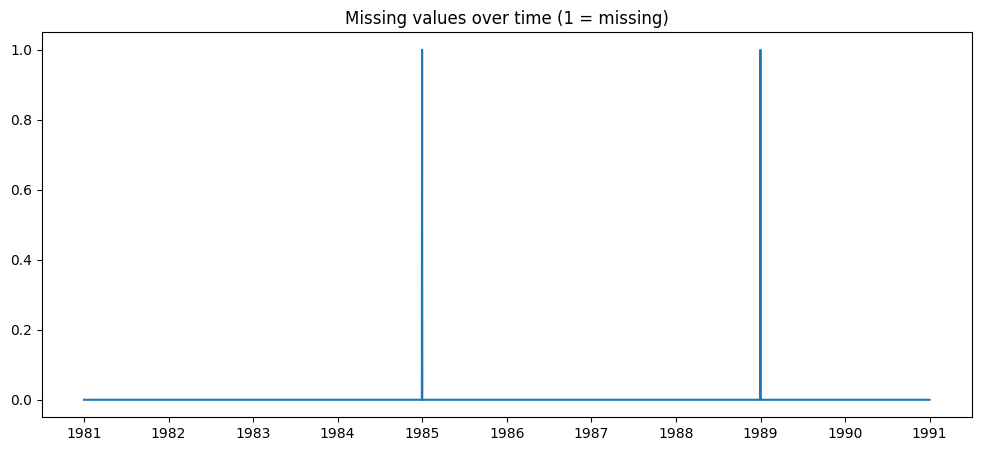

In [25]:
# Ensure index is datetime and sorted
df.index = pd.to_datetime(df.index)
df.sort_index(inplace=True)

# Check frequency
print("Index freq before reindex:", df.index.inferred_freq)

# Reindex to daily frequency and mark missing dates
full_idx = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
df = df.reindex(full_idx)
print("Missing dates after reindex:", df['temp'].isnull().sum())

# Visualize missing pattern (simple)
plt.plot(df['temp'].isnull().astype(int))
plt.title("Missing values over time (1 = missing)")
plt.show()


In [26]:
# Simple safe imputation (documenter ce choix)
df['Temp_interpolated'] = df['temp_cleaned'].interpolate(method='time')  # time-interpolation

# Check
print("Missing after interpolation:", df['Temp_interpolated'].isnull().sum())

# Forward fill + backward fill pour les 1–2 valeurs restantes
df['Temp_interpolated'].fillna(method='ffill', inplace=True)
df['Temp_interpolated'].fillna(method='bfill', inplace=True)

print("Final missing:", df['Temp_interpolated'].isnull().sum())



Missing after interpolation: 0
Final missing: 0


/tmp/ipykernel_70710/1674779440.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Temp_interpolated'].fillna(method='ffill', inplace=True)
/tmp/ipykernel_70710/1674779440.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Temp_interpolated'].fillna(method='ffill', inplace=True)
/tmp/ipykernel_70710/1674779440.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an i

In [27]:
series = df['Temp_interpolated'].dropna()

# Basic stats
desc = series.describe()
skewness = series.skew()
kurtosis = series.kurtosis()
print(desc)
print("Skewness:", skewness)
print("Kurtosis:", kurtosis)

# Additional moments & tests
print("Median:", series.median())
print("IQR:", series.quantile(0.75) - series.quantile(0.25))


count    3652.000000
mean       11.181175
std         4.067777
min         0.000000
25%         8.300000
50%        11.000000
75%        14.000000
max        26.300000
Name: Temp_interpolated, dtype: float64
Skewness: 0.17694156600342673
Kurtosis: -0.07379144407489635
Median: 11.0
IQR: 5.699999999999999


Our time series have 3652 observations over about one Year . the mean and the median values are very close wetnessing that the serie is symetric . the temperature are from 0 to 26 degrees . The statistical desciptions show that our data are idel for good future modeling 

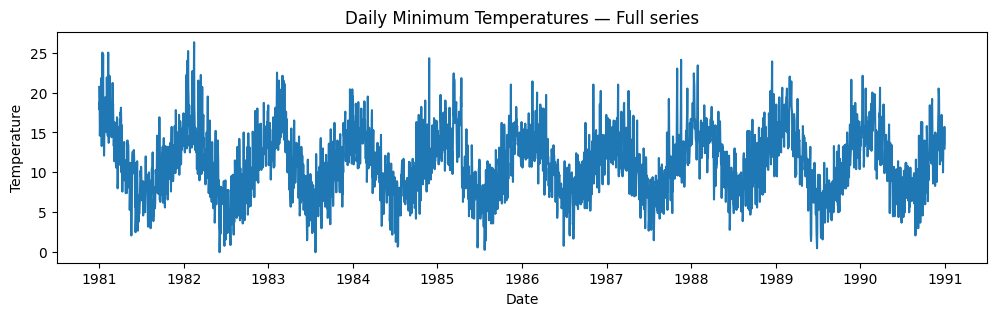

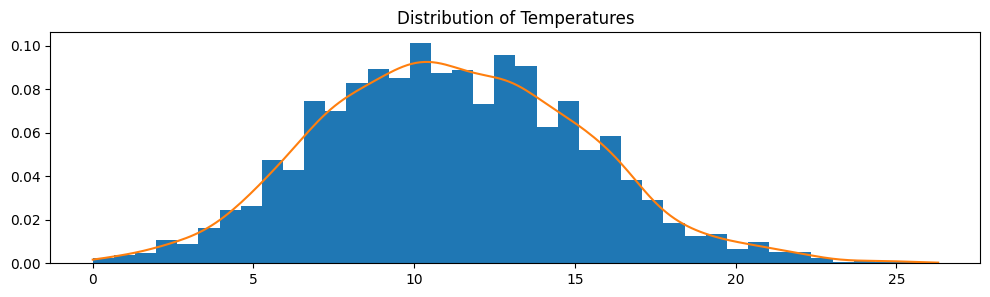

/tmp/ipykernel_70710/2450646951.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([series[series.index.month==m] for m in range(1,13)], labels=range(1,13))


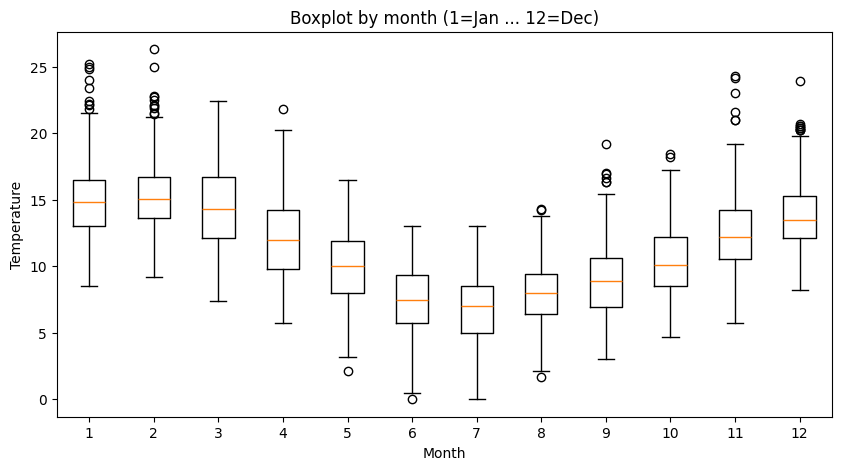

In [28]:
# Full series
plt.figure(figsize=(12,3))
plt.plot(series)
plt.title("Daily Minimum Temperatures — Full series")
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.show()

#  Histogram + empirical density
plt.figure(figsize=(12,3))
plt.hist(series, bins=40, density=True)
# overlay kernel density using scipy gaussian_kde
kde = stats.gaussian_kde(series.dropna())
xs = np.linspace(series.min(), series.max(), 200)
plt.plot(xs, kde(xs))
plt.title("Distribution of Temperatures")
plt.show()

#  Boxplot by month to reveal seasonality magnitude
df_month = series.groupby(series.index.month).apply(list)
plt.figure(figsize=(10,5))
plt.boxplot([series[series.index.month==m] for m in range(1,13)], labels=range(1,13))
plt.title("Boxplot by month (1=Jan ... 12=Dec)")
plt.xlabel("Month")
plt.ylabel("Temperature")
plt.show()


the least temperatiures are recorded in june , july and august in average . while this fact seem weird it reflect well the reality of the south hemisphere where seasons are oopposed to what we can can observe in europe( north hemisphere
 ) . 

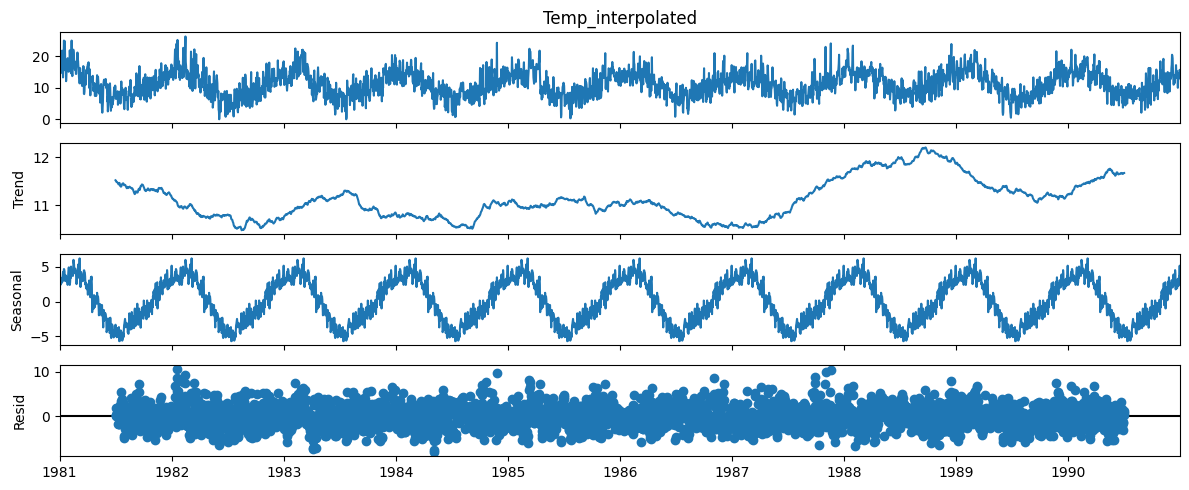

In [29]:
# Choose additive or multiplicative depending on variance behavior (visual inspection).
decomp = seasonal_decompose(series, model='additive', period=365)  # daily data with yearly seasonality
decomp.plot()
plt.show()


- trend :This represents the long-term direction or global pattern in the data. In our Melbourne temperature series, we observe a slight long-term warming over the 10-year period.
- seasonal : This captures repeating patterns at fixed intervals, e.g., winter (June–July) and summer (December–February). Seasonality explains the predictable yearly fluctuations. 
-our residual are random 

## Autocorrelation 

we measure the correlation of the time series with its own lagged values so as to  indnetify repeating patterns 

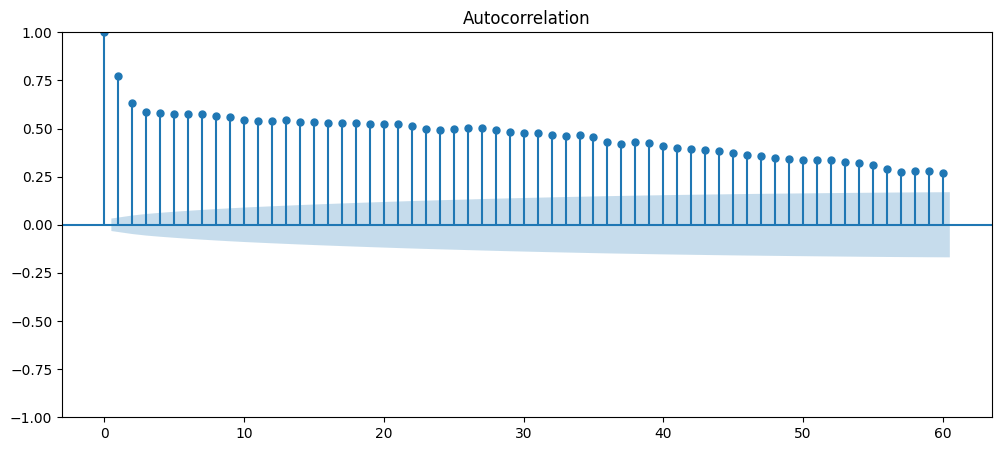

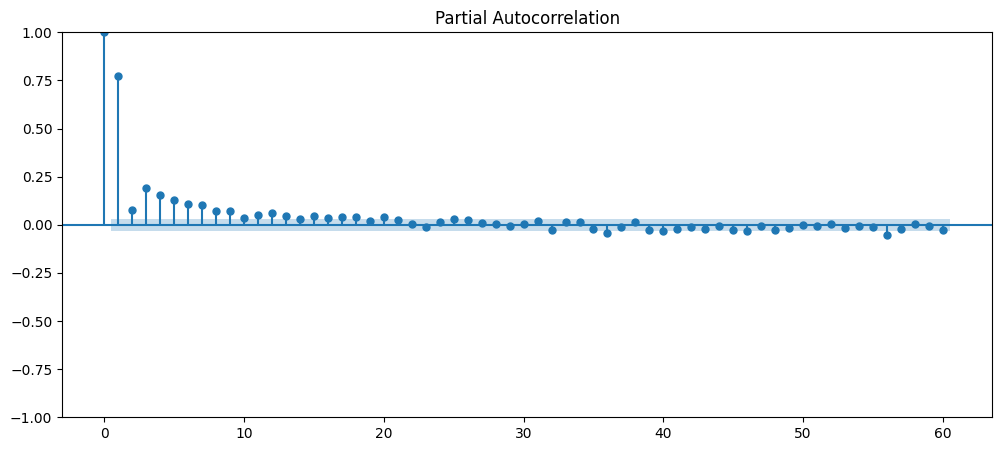

Top lag autocorrelations (1-30): [np.float64(0.7747511917096175), np.float64(0.6309334201283815), np.float64(0.5862623074256103), np.float64(0.5792839199387174), np.float64(0.5789137453491127), np.float64(0.5770396154310118), np.float64(0.5760152672682808), np.float64(0.568900334831732), np.float64(0.562832498360505), np.float64(0.5493848140996638)]


In [30]:
# Autocorrelation plot
plot_acf(series, lags=60)
plt.show()

plot_pacf(series, lags=60, method='ywm')
plt.show()

# Numeric top autocorrelations
autocorrs = [series.autocorr(lag=l) for l in range(1,31)]
print("Top lag autocorrelations (1-30):", autocorrs[:10])


the autocorrelation function decays over the time witenessing that our series is non stationary that is to say our temperature values are dependants

## Formal stationary test for confirmation 

In [32]:
from statsmodels.tsa.stattools import adfuller

result_adf = adfuller(df['Temp_interpolated'])
print("ADF Statistic:", result_adf[0])
print("p-value:", result_adf[1])
for key, value in result_adf[4].items():
    print('Critical Value (%s): %.3f' % (key, value))


ADF Statistic: -4.436765044195099
p-value: 0.00025538387462353
Critical Value (1%): -3.432
Critical Value (5%): -2.862
Critical Value (10%): -2.567


In [34]:
from statsmodels.tsa.stattools import kpss

result_kpss = kpss(df['Temp_interpolated'], regression='c')  # 'c' = constant
print("KPSS Statistic:", result_kpss[0])
print("p-value:", result_kpss[1])
for key, value in result_kpss[3].items():
    print('Critical Value (%s): %.3f' % (key, value))


KPSS Statistic: 0.05548249768655271
p-value: 0.1
Critical Value (10%): 0.347
Critical Value (5%): 0.463
Critical Value (2.5%): 0.574
Critical Value (1%): 0.739


/tmp/ipykernel_70710/3778926921.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result_kpss = kpss(df['Temp_interpolated'], regression='c')  # 'c' = constant


Conversely to what we thought the 2 tested conducted pointed out that out  that the series is stationary 